# Problem Description

This notebook classifies movie reviews as positive or negative using the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

We'll use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

**1. Load the Requried Libraries**

In [1]:
from keras.datasets import imdb #To import the IMDB dataset
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,MaxPool1D
from sklearn import metrics #to evaluate the model
import nltk #for data preprocessing
from nltk.corpus import stopwords #to remove stopwords
from nltk.stem import WordNetLemmatizer #to convert the word to base form
nltk.download('stopwords')
nltk.download('wordnet')
stop = stopwords.words('english')
import re 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**2.  Load the data**

Keras provides access to the IMDB dataset built-in. The imdb.load_data() function allows you to load the dataset in a format that is ready for use in neural network and deep learning models.

The words have been replaced by integers that indicate the ordered frequency of each word in the dataset. The sentences in each review are therefore comprised of a sequence of integers.

In [0]:
top_words = 10000 # Here we will use top 10000 words
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

In [4]:
#Let's look into the Shape of the data
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((25000,), (25000,), (25000,), (25000,))

In [5]:
#to get the length of the largest review
lengths = []
for i in range(0,len(X_train)):
  lengths.append(len(X_train[i]))
max(lengths)  

2494

In [6]:
pd.Series(lengths).describe() # To look into the distribution of the lengths 

count    25000.000000
mean       238.713640
std        176.497204
min         11.000000
25%        130.000000
50%        178.000000
75%        291.000000
max       2494.000000
dtype: float64

In [0]:
#Let's see how the review looks like.
X_train[1]

**3. Data Preprocessing**

In [0]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [0]:
sorted(word_index.items(),key = lambda kv: kv[1]) #Sorted by values

In [11]:
decode_review(X_train[1])

"<START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal <UNK> the hair is big lots of boobs <UNK> men wear those cut <UNK> shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

In [0]:
for i in range(0,len(X_train)):
  X_train[i] = decode_review(X_train[i])

In [13]:
X_train[5]

"<START> begins better than it ends funny that the russian submarine crew <UNK> all other actors it's like those scenes where documentary shots br br spoiler part the message <UNK> was contrary to the whole story it just does not <UNK> br br"

In [14]:
y_train[1:10]

array([0, 0, 1, 0, 0, 1, 0, 1, 0])

In [0]:
def preprocessing(text):
  text = re.sub(r'<\w+>','',text)# We will remove the words that starts with '<' and ends with '>'
  text = re.sub(r'[^a-zA-Z]',' ',text)#To remove the numbers and special characters
  text = ' '.join([word for word in text.split()])# To remove the whitespaces
  text = ' '.join([WordNetLemmatizer().lemmatize(word) for word in text.split() if word not in stop])#To remove the stop words and to convert the words to base form
  return text

In [0]:
for i in range(0,len(X_train)):
  X_train[i] = preprocessing(X_train[i])

In [17]:
#After Preprocessing the data
X_train[5]

'begin better end funny russian submarine crew actor like scene documentary shot br br spoiler part message contrary whole story br br'

In [0]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 291
# This is fixed.
EMBEDDING_DIM = 100 #To convert the each word to vector length of 100.

In [19]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8365 unique tokens.


In [0]:
X = tokenizer.texts_to_sequences(X_train) # We will convert the text data to sequence number.

In [0]:
X[1]

In [22]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (25000, 291)


**4. Model Building**

In [24]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Dropout(0.2))# to prevent the model from overfitting
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 291, 100)          1000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 291, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________
None


**4a. Train the Model**

In [25]:
epochs = 5
batch_size = 64
history = model.fit(X, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 234s 10ms/step - loss: 0.4591 - acc: 0.7830 - val_loss: 0.3681 - val_acc: 0.8452
Epoch 2/5
22500/22500 [==============================] - 228s 10ms/step - loss: 0.2840 - acc: 0.8904 - val_loss: 0.3314 - val_acc: 0.8644
Epoch 3/5
22500/22500 [==============================] - 229s 10ms/step - loss: 0.2320 - acc: 0.9108 - val_loss: 0.3291 - val_acc: 0.8696
Epoch 4/5
22500/22500 [==============================] - 229s 10ms/step - loss: 0.1926 - acc: 0.9267 - val_loss: 0.3546 - val_acc: 0.8820
Epoch 5/5
22500/22500 [==============================] - 230s 10ms/step - loss: 0.1544 - acc: 0.9436 - val_loss: 0.3874 - val_acc: 0.8708


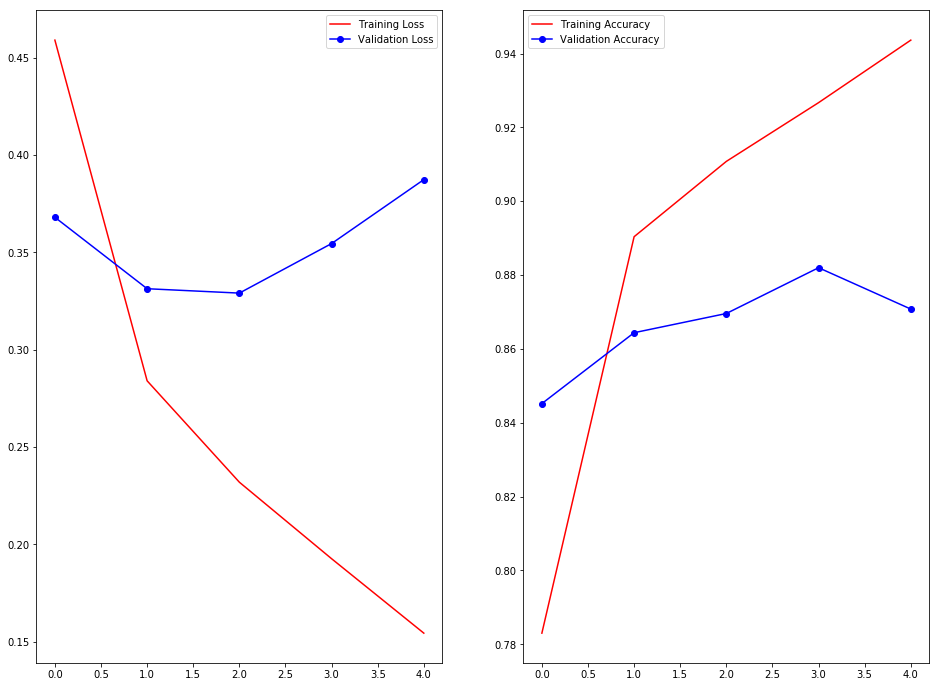

In [47]:
plt.figure(figsize = (16,12))
plt.subplot(121)
plt.plot(history.history['loss'],'r',label = 'Training Loss')
plt.plot(history.history['val_loss'],'-bo',label = 'Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['acc'],'r',label = 'Training Accuracy')
plt.plot(history.history['val_acc'],'-bo',label = 'Validation Accuracy')
plt.legend()


In [27]:
model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2.add(Dropout(0.2))# to prevent the model from overfitting
model2.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 291, 100)          1000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 291, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 1,150,751
Trainable params: 1,150,751
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
history2 = model2.fit(X, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 236s 10ms/step - loss: 0.4336 - acc: 0.7949 - val_loss: 0.3361 - val_acc: 0.8620
Epoch 2/5
22500/22500 [==============================] - 232s 10ms/step - loss: 0.2741 - acc: 0.8940 - val_loss: 0.3284 - val_acc: 0.8616
Epoch 3/5
22500/22500 [==============================] - 231s 10ms/step - loss: 0.2228 - acc: 0.9147 - val_loss: 0.3411 - val_acc: 0.8664
Epoch 4/5
22500/22500 [==============================] - 230s 10ms/step - loss: 0.1873 - acc: 0.9304 - val_loss: 0.3644 - val_acc: 0.8584
Epoch 5/5
22500/22500 [==============================] - 230s 10ms/step - loss: 0.1589 - acc: 0.9421 - val_loss: 0.3747 - val_acc: 0.8548


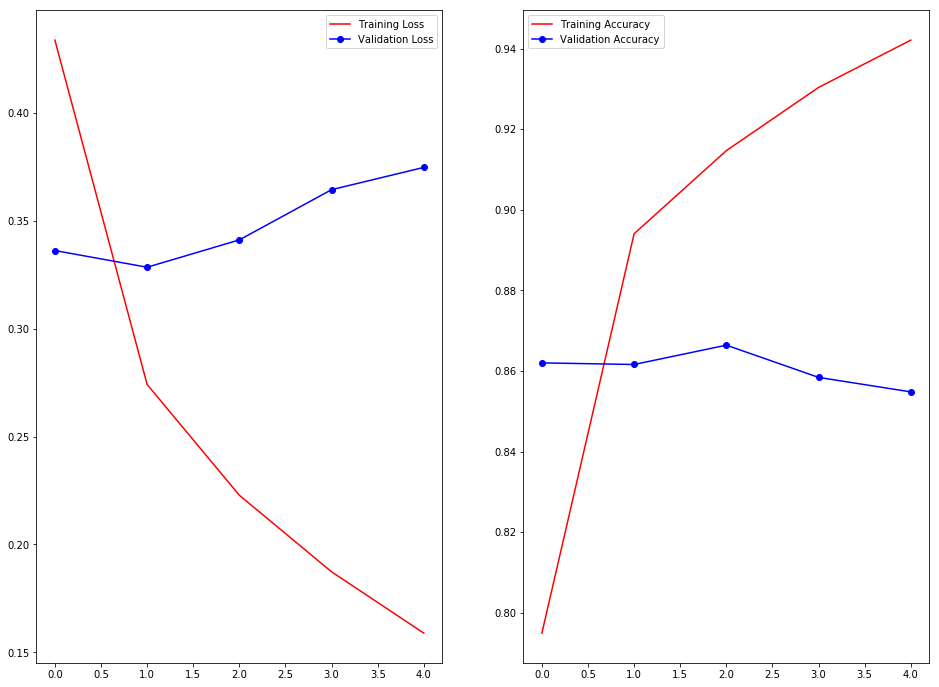

In [48]:
plt.figure(figsize = (16,12))
plt.subplot(121)
plt.plot(history2.history['loss'],'r',label = 'Training Loss')
plt.plot(history2.history['val_loss'],'-bo',label = 'Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(history2.history['acc'],'r',label = 'Training Accuracy')
plt.plot(history2.history['val_acc'],'-bo',label = 'Validation Accuracy')
plt.legend()

In [29]:
model3 = Sequential()
model3.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model3.add(Dropout(0.2))# to prevent the model from overfitting
model3.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPool1D(pool_size = 2))
model3.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 291, 100)          1000000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 291, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 291, 64)           19264     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 145, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               212000    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 1,231,465
Trainable params: 1,231,465
Non-trainable params: 0
___________________________________________

In [30]:
history3 = model3.fit(X, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 115s 6ms/step - loss: 0.4235 - acc: 0.7910 - val_loss: 0.2939 - val_acc: 0.8806
Epoch 2/5
20000/20000 [==============================] - 112s 6ms/step - loss: 0.2402 - acc: 0.9063 - val_loss: 0.3008 - val_acc: 0.8784
Epoch 3/5
20000/20000 [==============================] - 112s 6ms/step - loss: 0.1804 - acc: 0.9339 - val_loss: 0.3041 - val_acc: 0.8776
Epoch 4/5
20000/20000 [==============================] - 112s 6ms/step - loss: 0.1398 - acc: 0.9493 - val_loss: 0.3447 - val_acc: 0.8778
Epoch 5/5
20000/20000 [==============================] - 112s 6ms/step - loss: 0.1039 - acc: 0.9642 - val_loss: 0.3995 - val_acc: 0.8780


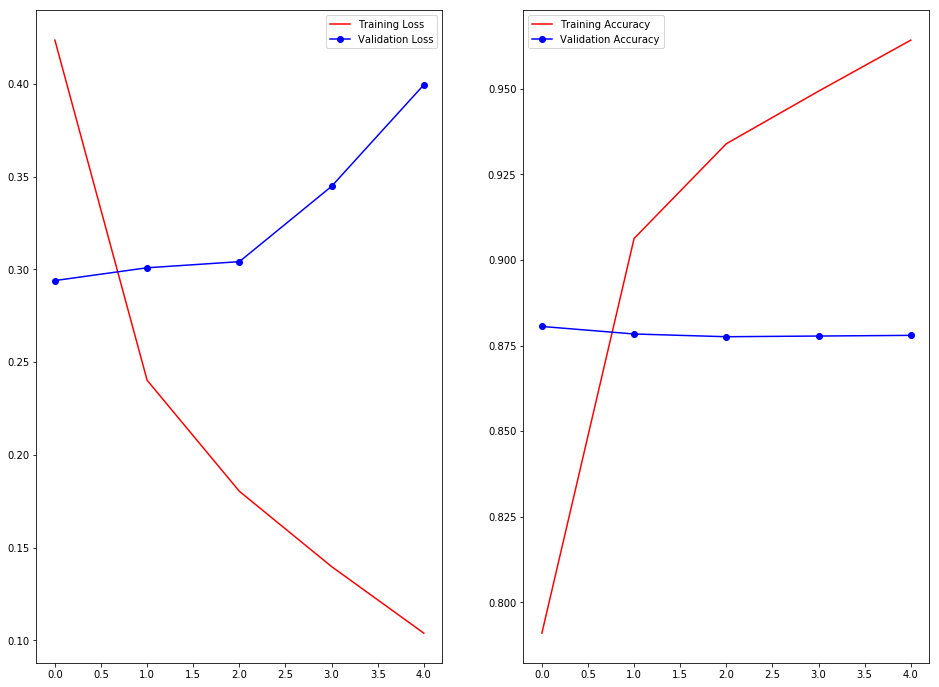

In [49]:
plt.figure(figsize = (16,12))
plt.subplot(121)
plt.plot(history3.history['loss'],'r',label = 'Training Loss')
plt.plot(history3.history['val_loss'],'-bo',label = 'Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(history3.history['acc'],'r',label = 'Training Accuracy')
plt.plot(history3.history['val_acc'],'-bo',label = 'Validation Accuracy')
plt.legend()

**4b. Test the model on Test data**

In [0]:
#Preprocess the test data
def text_preprocess(text):
  text = decode_review(text)
  text = preprocessing(text)
  return text

In [0]:
for i in range(0,len(X_test)):
  X_test[i] = text_preprocess(X_test[i])

In [0]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
test_predictions = model.predict_classes(X_test)

In [35]:
print(metrics.classification_report(test_predictions,y_test))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85     11851
           1       0.88      0.84      0.86     13149

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.85     25000
weighted avg       0.86      0.86      0.86     25000



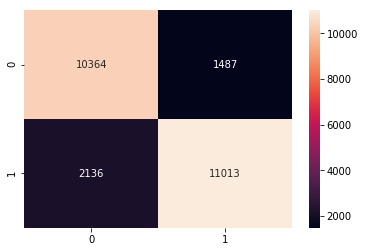

In [36]:
#Confusion Matrix
sns.heatmap(metrics.confusion_matrix(test_predictions,y_test),annot = True,fmt = 'd')

In [0]:
test_predictions2 = model2.predict_classes(X_test)

In [39]:
print(metrics.classification_report(test_predictions2,y_test))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85     13683
           1       0.80      0.88      0.84     11317

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



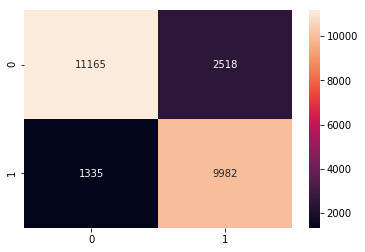

In [40]:
sns.heatmap(metrics.confusion_matrix(test_predictions2,y_test),annot = True,fmt = 'd')

In [0]:
test_predictions3 = model3.predict_classes(X_test)

In [41]:
print(metrics.classification_report(test_predictions3,y_test))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12551
           1       0.85      0.86      0.86     12449

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



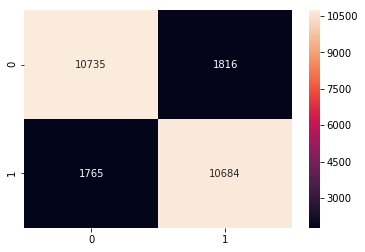

In [42]:
sns.heatmap(metrics.confusion_matrix(test_predictions3,y_test),annot = True,fmt = 'd')